In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs  #clonning traffic dataset from Bitbucket 

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-sign   # .p is picault file it contains serialized data # !ls - lists all the directory names present in there

ls: cannot access 'german-traffic-sign': No such file or directory


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle #to unpickle the files , deserialize the python .p format files
import pandas as pd
import cv2
 
 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline

In [ ]:
np.random.seed(0)

In [ ]:
# TODO: Implement load the data here.
   #with is used with open function as with will automatically close the opened file without the need of calling the close function
with open('german-traffic-signs/train.p', 'rb') as f: #storing all data in f
    train_data = pickle.load(f)    # .load used to load the unpickled content #rb =  to open the reading file in binary format
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f) 
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

print(type(train_data))  #all three data in form of dictionary containing key value pairs

<class 'dict'>


In [ ]:

 
    
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']  #accessing the features and labels keys from the complete dictionary
X_val, y_val = val_data['features'], val_data['labels'] #labels are the class value to which the features belong ,helps the neural network learn that a function belongs to a given class(feature)
X_test, y_test = test_data['features'], test_data['labels'] #features are the pixel representation of the image
 
#already 4 dimensional
print(X_train.shape) #shape is (number of images ,dimension 32*32 ,, depth(number of channels - RGB format))
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
#use assert to check that your complex data was imported correctly by matching - number of images == number of labels
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."


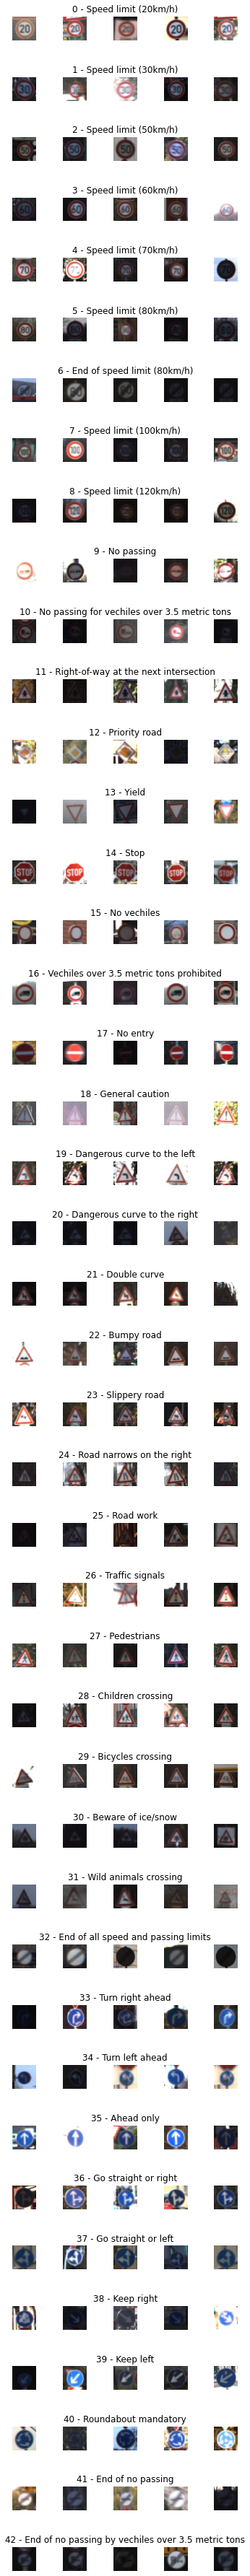

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows(): #in order to iterate over the entire dataset rows
        x_selected = X_train[y_train == j] #x_selected has the number of images present in each class
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2: #to set the title value above every row
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected)) #array containing no. of images in each class

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


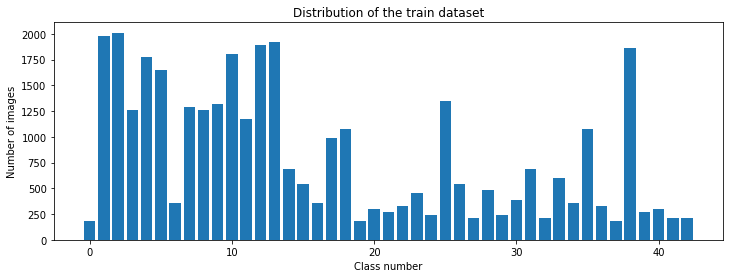

In [ ]:
#to plot the number of images in each class
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


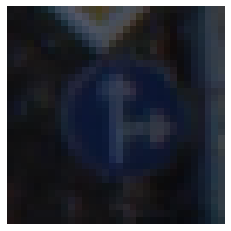

In [ ]:
import cv2
 #take a random image that is to be pre-processed
plt.imshow(X_train[1000])  #1000th index
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
#function to convert RGB to grey-scale , as the colour is varying for every image , the main focus should be on curves , shape, edges of the image
def grayscale(img): #also converting to grey scale will reduce the depth of images ,hence fewer parameters as input for network 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


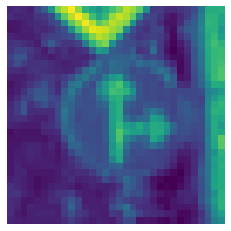

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
#histogram equalization - to standardize lighting - it just spreads the histogram to the ends and helps to normalize lighting on all of our images
#also helps in increasing contrast in our image for better feature extraction

def equalize(img):  #to re-assign pixel intensity values for more uniform distribution of intensities
    img = cv2.equalizeHist(img)  #histogram equalisation , it will only accept grey scale images as depth
    return img

(32, 32)


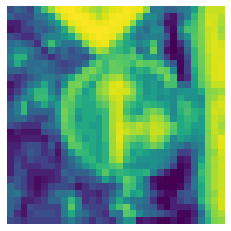

In [ ]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
#function to be used for the entire dataset
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255   #normalization to bring all pixel values b/w 0 and 1
    return img

(34799, 32, 32)


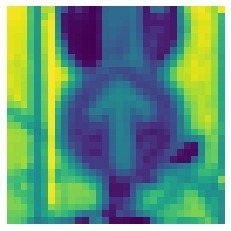

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))   #list is used to store the result we get from mapping
#and then a numpy array is used to store the list of images
#map will iterate through entire X_train data and apply the preprocess function to it
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)]) #to get a random image from our processed X_Train 
plt.axis('off')
print(X_train.shape)


In [ ]:
#to reshape it as it should have a depth 1 when fed to the CNN , to get it properly formatted for the network
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)


In [ ]:
#DATA AUGMENTATION - to introduce redundancy , improve accuracy of NN
from keras.preprocessing.image import ImageDataGenerator
                         #there are 5 parameters in ImageDataGenerator that we are going to modify
datagen = ImageDataGenerator(width_shift_range=0.1,  #0.1 represents that max of 10% of horizontal shift is allowed
                            height_shift_range=0.1,
                            zoom_range=0.2,  #this means we can zoom up to 1.2 and zoom out to 0.8
                            shear_range=0.1, #image bent at some angle in a shear way
                            rotation_range=10.)
 
datagen.fit(X_train)

(15, 32, 32, 1)


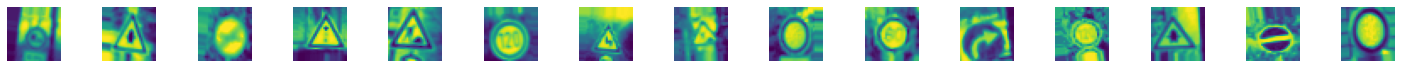

In [ ]:
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15) #creating 15 new images when called
X_batch, y_batch = next(batches)
                   #next functions calls the batches to produce new inputs equal to size of batch size
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
                     #(no. of rows , no. of columns , figsize)
#instance of our figure , and the axis
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [ ]:
#hot encoding of the data
y_train = to_categorical(y_train, 43)
                        #inputs(data that has to be hot encoded , number of classes)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
# create model
 
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu')) #no. of adjustable parameters :- 60(features)*5*5(kernel size) + 60(bias) = 1560
  
  #inputs for conv2D( number of filters , size of filters , size of image being fed(input_shape) , activation function) 
  #more filters means more feature extraction
  #the output of this layer will be (32,32,1) -> (28,28,30) as there are 30 filters and each filter will add a depth of 1 
  #more number of filters equals more computing power
  #as kernel size (5,5) 2 units lost from each border turning it from 32 to 28 
  
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten()) #flattening is done to format the model so that the convoluted data can be fed to the dense or fully connected layer
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5)) #0.5 refers the amount of nodes that will be dropped during each update
  model.add(Dense(43, activation='softmax'))  #output layer , number of nodes = number of classes
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  # the model is training over loss thus - categorical_crossentropy as it is a multiclass dataset , metrics defines the thing in which we are interested(here - accuracy)
  return model

Reference  (https://keras.rstudio.com/reference/fit_generator.html), the steps_per_epoch = int(len(X_train)/batch_size),

In [ ]:
model = modified_model()
print(model.summary())
  #CHANGE THIS CODE SNIPPET WITH THE OTHER .fit -> .fit_generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=695,  # '''steps_per_epoch = x_train.shape[0]/50'''   #amount of batches that are bring generated per epoch
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


695/695 [==============================] - 14s 19ms/step - loss: 1.7186 - accuracy: 0.5095 - val_loss: 0.3422 - val_accuracy: 0.9014
Epoch 2/10
695/695 [==============================] - 13s 18ms/step - loss: 0.5347 - accuracy: 0.8336 - val_loss: 0.1032 - val_accuracy: 0.9626
Epoch 3/10
695/695 [==============================] - 13s 18ms/step - loss: 0.3249 - accuracy: 0.8986 - val_loss: 0.0796 - val_accuracy: 0.9760
Epoch 4/10
695/695 [==============================] - 15s 22ms/step - loss: 0.2491 - accuracy: 0.9238 - val_loss: 0.0869 - val_accuracy: 0.9755
Epoch 5/10
695/695 [==============================] - 13s 19ms/step - loss: 0.1980 - accuracy: 0.9382 - val_loss: 0.0609 - val_accuracy: 0.9819
Epoch 6/10
695/695 [==============================] - 19s 27ms/step - loss: 0.1651 - accuracy: 0.9485 - val_loss: 0.0674 - val_accuracy: 0.9785
Epoch 7/10
695/695 [==============================] - 15s 21ms/step - loss: 0.1423 - accuracy: 0.9544 - val_loss: 0.0630 - val_accuracy: 0.9841
Epo

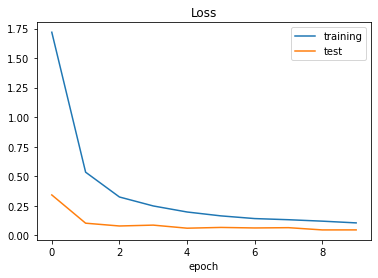

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training','test'])

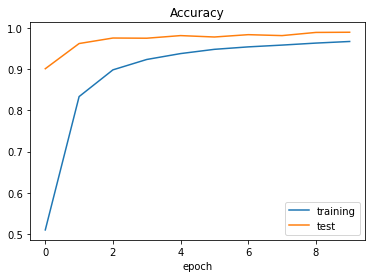

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
 
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)

Test score: 0.12633946537971497
Test accuracy: 0.9676167964935303
(32, 32)
predicted sign: [34]


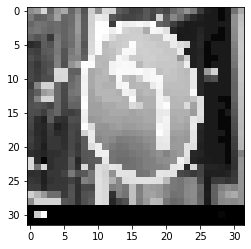

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

Other sample signs to test

https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg

